In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 21 12:41:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 177 µs (started: 2022-02-21 12:42:02 +00:00)


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 10.1 ms (started: 2022-02-21 12:42:02 +00:00)


In [ ]:
!pip install --quiet optuna

     |████████████████████████████████| 308 kB 8.5 MB/s 
     |████████████████████████████████| 210 kB 45.7 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 113 kB 50.1 MB/s 
     |████████████████████████████████| 149 kB 34.4 MB/s 
     |████████████████████████████████| 49 kB 3.6 MB/s 
time: 11.5 s (started: 2022-02-21 12:42:02 +00:00)


In [ ]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params

import optuna # hyeperparam optimization 

time: 5.52 s (started: 2022-02-21 12:42:13 +00:00)


# Variables

## Paths

In [ ]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
zip_trained_model_dir = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Best DL models after using optuna/Final DL model/final_model.zip'
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220221_12H42/
time: 329 ms (started: 2022-02-21 12:42:19 +00:00)


## Other

In [ ]:
# seed
random_seed = 42

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'


# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = None  # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


model_dict = {
    'VGG16' : tf.keras.applications.VGG16(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False), 
    'VGG19' : tf.keras.applications.VGG19(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False), 
    'EFB1' : tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'EFB3' : tf.keras.applications.EfficientNetB3(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'resnet50' : tf.keras.applications.resnet50.ResNet50(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV2': tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV3Large': tf.keras.applications.MobileNetV3Large(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV3Small': tf.keras.applications.MobileNetV3Small(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),    
    'InceptionResNetV2': tf.keras.applications.InceptionResNetV2(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'InceptionV3': tf.keras.applications.InceptionV3(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNet': tf.keras.applications.MobileNet(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'Xception': tf.keras.applications.Xception(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
}

# retrain or load previously trained
retrain_model=True
# previously trained model dir 
model_dir = export_dir if retrain_model else "/content/"

# epoch
epochs = 20 # 5 
# define base model  
model_name = 'EFB1'
base_model = model_dict[model_name]
# learing rate 
lr =1e-4
lr_2nd_step = 4.495828846126947e-05
layer_unfreeze = 250  # number to unfreeze 2nd step 
# batch size 
batch_size = 16 #32
# classifier architecture 
n_units_1, n_units_2 = 1024,512
dropout_1, dropout_2 = 0.3 , 0.2 



# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


83697664/83683744 [==============================] - 1s 0us/step
time: 51.5 s (started: 2022-02-21 12:42:19 +00:00)


# Load & filter data

## Unzip images

In [ ]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/618224.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/619311.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/619904.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/620199.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/620814.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/621320.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/622509.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/624754.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/627015.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/627187.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/629081.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune

In [ ]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 17.1 ms (started: 2022-02-21 12:45:41 +00:00)


## File_path df

In [ ]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


215410 rows in the file


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 3.37 s (started: 2022-02-21 12:45:41 +00:00)


In [ ]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 9.25 ms (started: 2022-02-21 12:45:44 +00:00)


In [ ]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 352 ms (started: 2022-02-21 12:45:44 +00:00)


In [ ]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 212 ms (started: 2022-02-21 12:45:44 +00:00)


In [ ]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 69.2 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 48.6 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 92.9 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 24.8 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 40.5 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

time: 3.51 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 16.1 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
5,/content/RAW DATA/IMAGES/2006/Agaricus/682.jpg,Agaricaceae,0
6,/content/RAW DATA/IMAGES/2006/Agaricus/685.jpg,Agaricaceae,0
7,/content/RAW DATA/IMAGES/2006/Agaricus albolut...,Agaricaceae,0
8,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0
9,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0


time: 89.1 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.48 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 35787


,label,gbif_info.family,size
0,0,Agaricaceae,5254
1,1,Strophariaceae,4494
2,2,Amanitaceae,4769
3,3,Boletaceae,6060
4,4,Tricholomataceae,4967
5,5,Cortinariaceae,4124
6,6,Russulaceae,6119


time: 47.3 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Agaricaceae',
 '1': 'Strophariaceae',
 '2': 'Amanitaceae',
 '3': 'Boletaceae',
 '4': 'Tricholomataceae',
 '5': 'Cortinariaceae',
 '6': 'Russulaceae'}

time: 7.73 ms (started: 2022-02-21 12:45:45 +00:00)


## Train/test split

In [ ]:
#train/test 
# Train/test
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
# train / val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
print(df_train_.shape,df_val_.shape,df_test.shape)

(22903, 3) (5726, 3) (7158, 3)
time: 99.1 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 37 ms (started: 2022-02-21 12:45:45 +00:00)


### Plot few images

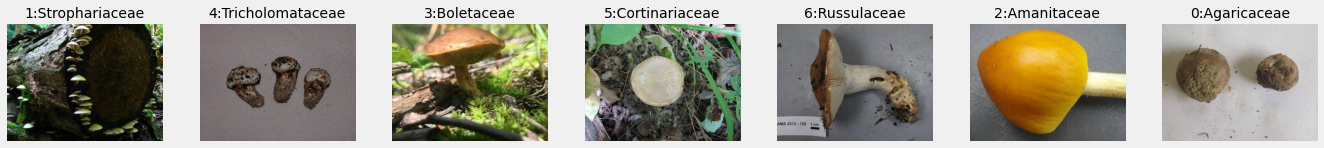

time: 734 ms (started: 2022-02-21 12:45:45 +00:00)


In [ ]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

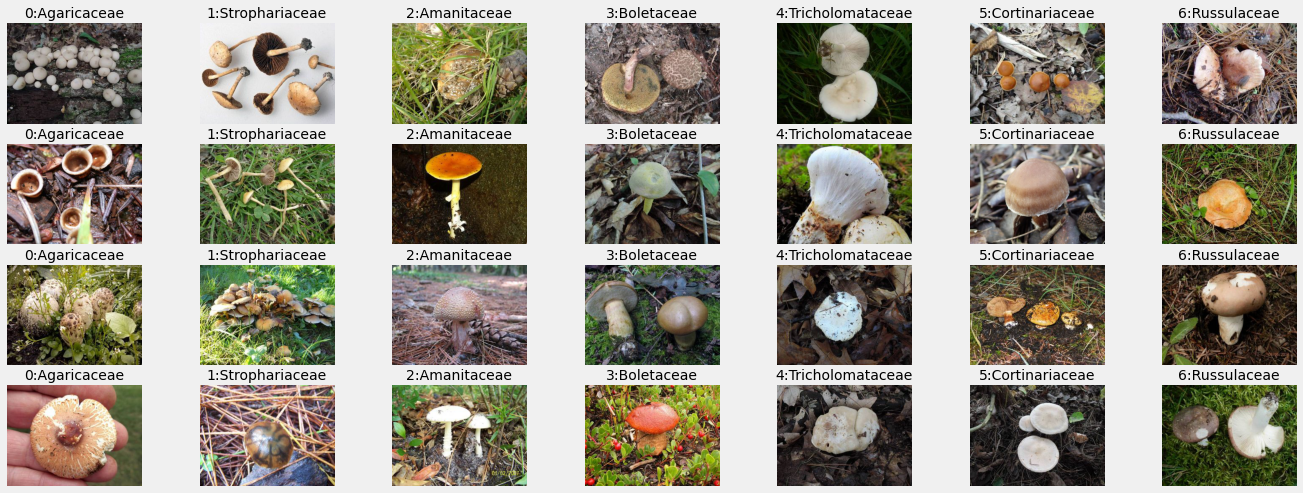

time: 2.15 s (started: 2022-02-21 12:45:46 +00:00)


In [ ]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Callbacks & Fonctions

In [ ]:
# pour catcher la convergence lors de la première phase 
early_stopping_step1 = EarlyStopping(
                                patience=2, # Attendre 2 epochs avant application
                                min_delta = 0.02, # si au bout de 2 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

early_stopping_step2 = EarlyStopping(
                                patience=3, # Attendre 5 epochs avant application
                                min_delta = 0.02, # si au bout de 4 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=2, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 14.4 ms (started: 2022-02-21 12:45:48 +00:00)


In [ ]:
def plot_history(history,pathinfos):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history['loss'])), history['loss'], '-o', label = "training")
  plt.plot(range(len(history['val_loss'])), history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history['accuracy'])), history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history['val_accuracy'])), history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 20.1 ms (started: 2022-02-21 12:45:48 +00:00)


In [ ]:
def plot_history_2steps(history,pathinfos,max_epoch_freeze=None):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))
  
  x = np.arange(1,(len(history['loss']))+1,1)
  plt.subplot(121)
  plt.plot(x, history['loss'], '-o', label = "training")
  plt.plot(x, history['val_loss'],  '-o',label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(x, history['accuracy'], '-o', label = "training")
  plt.plot(x, history['val_accuracy'], '-o', label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black' )
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 31.5 ms (started: 2022-02-21 12:45:48 +00:00)


In [ ]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 56.8 ms (started: 2022-02-21 12:45:48 +00:00)


In [ ]:
def conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(20,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')
  #add classif report 
  # plt.axvline(x=len(classes)+2, color = 'black')
  rep = metrics.classification_report(y_test_class, test_pred_class)
  plt.text(len(classes)+2.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+3, len(classes)-1, rep)
  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+11.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+12, (len(classes)+2)/2, lab_dict)



  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1.7,ha = 'center')


  # plt.show()
  plt.close()
  return fig

time: 66.6 ms (started: 2022-02-21 12:45:48 +00:00)


# Best model fit

In [ ]:
# csv start path infos 
if retrain_model:
  pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
  print(export_dir,'\n',pathinfos)

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220221_12H42/ 
 EFB1_(240, 320)_7families_28629_images
time: 6.14 ms (started: 2022-02-21 12:45:48 +00:00)


## First step (warmup)

In [ ]:
if retrain_model:
  # Clear clutter from previous TensorFlow graphs.
  tf.keras.backend.clear_session()
  # datagen 
  # train 
  train_data_generator = ImageDataGenerator(
                                            # rotation_range=0.1,horizontal_flip= True,vertical_flip= True
                                            ) 
  train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
                                                            x_col = "drive_file_path",y_col="label", 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')
  # val
  val_data_generator = ImageDataGenerator() 
  val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                            x_col = "drive_file_path",y_col="label", 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')



  # construct model 
  # base + average 
  layers = [base_model,tf.keras.layers.GlobalAveragePooling2D()] 
  # dense + dropout 
  layers.append(tf.keras.layers.Dense(units = n_units_1, activation = 'relu'))
  layers.append(tf.keras.layers.Dropout(dropout_1))
  layers.append(tf.keras.layers.Dense(units = n_units_2, activation = 'relu'))
  layers.append(tf.keras.layers.Dropout(dropout_2))
  # prediction 
  layers.append(Dense(units = classes_count, activation = 'softmax'))
  #freeze/unfreeze all layers 
  for layer in base_model.layers:
      layer.trainable = False
  #create model 
  model = tf.keras.Sequential(layers,name = model_name)
  model.summary()
  # export summary model & param 
  with open(export_dir + pathinfos + '_modelsummary.txt', 'w') as f:
      model.summary(print_fn=lambda x: f.write(x + '\n'))
  # compilation 
  optimizer =  'Adam'
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
  print('lr={}'.format(K.eval(model.optimizer.lr)))
  # Entraînement
  tic = time.time() # timer start
  training_history_model_1 = model.fit(train_generator,epochs=epochs,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                    class_weight=class_weights,
                                  callbacks=[
                                            early_stopping_step1,
                                            reduce_learning_rate, 
                                              ],
                                  ) 

Found 22903 validated image filenames belonging to 7 classes.
Found 5726 validated image filenames belonging to 7 classes.
Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 drop

## 2nd step (unfreeze all layers)

In [ ]:
def scheduler(epoch):
    return lr * 1 / (1 + decay_rate * (epoch-max_epoch_freeze))
decay_rate=  2.0
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)

time: 2.22 ms (started: 2022-02-21 13:15:39 +00:00)


**************************************************setting base model trainable**************************************************
trainable_count = 8238469 / non_trainable_count =  176905
lr=4.495828761719167e-05 / batch_size = 16
Epoch 6/25
1431/1431 [==============================] - 231s 152ms/step - loss: 0.7898 - accuracy: 0.7216 - val_loss: 0.7893 - val_accuracy: 0.7183 - lr: 4.4958e-05
Epoch 7/25
1431/1431 [==============================] - 212s 148ms/step - loss: 0.5152 - accuracy: 0.8230 - val_loss: 0.7421 - val_accuracy: 0.7407 - lr: 1.4986e-05
Epoch 8/25
1431/1431 [==============================] - 212s 148ms/step - loss: 0.4120 - accuracy: 0.8619 - val_loss: 0.7530 - val_accuracy: 0.7482 - lr: 8.9917e-06
Epoch 9/25
1431/1431 [==============================] - 211s 148ms/step - loss: 0.3528 - accuracy: 0.8809 - val_loss: 0.7671 - val_accuracy: 0.7467 - lr: 6.4226e-06
Epoch 10/25
1431/1431 [==============================] - 212s 148ms/step - loss: 0.3203 - accuracy: 0.8943 - v

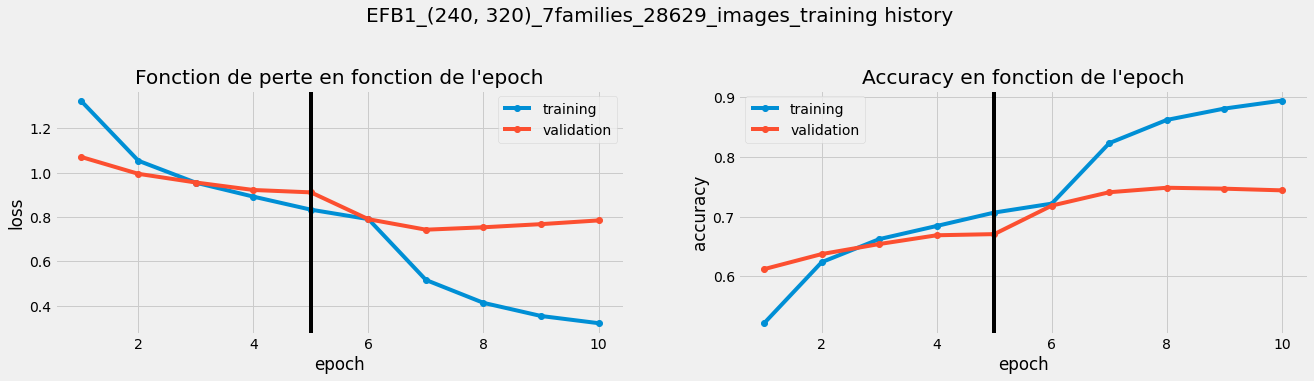

INFO:tensorflow:Assets written to: /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220221_12H42/final_model/assets
time: 22min 31s (started: 2022-02-21 13:15:39 +00:00)


In [ ]:
if retrain_model:
  #### FINE TUNING STEP cf https://www.tensorflow.org/guide/keras/transfer_learning
  print("*"*50 + 'setting base model trainable' + '*'*50)
  base_model_layers = model.get_layer(index=0).layers # get all efB1 layers when we load a model 
  for layer in base_model_layers[-layer_unfreeze:]:
        layer.trainable = True  if not isinstance(layer, keras.layers.BatchNormalization) else False # batchnorm has to be freeze
  # check
  print('trainable_count = {} / non_trainable_count =  {}'.format(count_params(model.trainable_weights),count_params(model.non_trainable_weights)))
  # compile 2nd setp 
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  # get last lr 
  # lr = training_history_model_1.history['lr'][-1] 
  lr =lr_2nd_step
  K.set_value(model.optimizer.learning_rate, lr) 
  print('lr={} / batch_size = {}'.format(K.eval(model.optimizer.lr),batch_size))
  # define last epoch number to keep up
  max_epoch_freeze = len(training_history_model_1.history['accuracy'])
  # fine tuning 
  training_history_model_2 = model.fit(train_generator,initial_epoch = max_epoch_freeze, # specify initial epoch 
                                  epochs=max_epoch_freeze + 20,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                    class_weight=class_weights,
                                  callbacks=[
                                              early_stopping_step2,
                                              reduce_learning_rate
                                              ],
                                  )
  # timer end 
  tac = time.time()
  time_to_fit = tic - tac
  print('fite time = {}'.format(-round(time_to_fit/60,1)))
  # concat history 
  training_history_model = {}
  for (k1,v1),(k2,v2) in zip(training_history_model_1.history.items(),training_history_model_2.history.items()):
    training_history_model[k1] = v1 +v2 
  # Plot hIStory 
  training_history_fig = plot_history_2steps(training_history_model,pathinfos,max_epoch_freeze)
  display(training_history_fig)
  # save fig
  training_history_fig.savefig(export_dir + pathinfos +  '_training_history.jpeg',bbox_inches = 'tight' )
  # save model 
  model.save(export_dir  +  'final_model')
  model.save(export_dir  +  'final_model.h5')

# Best model load & assess

## Load

In [ ]:
# restester ZIP 
# #test tavec zip 
# !unzip  '' -d "/content/"
# model = keras.models.load_model('/content/final_model')

time: 2.3 ms (started: 2022-02-21 13:38:11 +00:00)


In [ ]:
# load model 
if not retrain_model:
  main_path = "/content/final_model"   
  if os.path.exists(main_path)== False :
    !unzip "$zip_trained_model_dir"  -d "/content"
model = keras.models.load_model(model_dir +  'final_model')

time: 34.2 s (started: 2022-02-21 13:38:11 +00:00)


## Evaluate on test set 

In [ ]:
# predict 
print("*"*50 + 'Predicting labels' + '*'*50)
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
y_prob = model.predict(test_generator,len(df_test)//batch_size)
test_pred_class= np.argmax(y_prob , axis=1)

**************************************************Predicting labels**************************************************
Found 7158 validated image filenames belonging to 7 classes.
time: 34.6 s (started: 2022-02-21 13:38:45 +00:00)


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1051
           1       0.70      0.69      0.69       899
           2       0.81      0.82      0.82       954
           3       0.83      0.88      0.86      1212
           4       0.64      0.67      0.65       993
           5       0.66      0.66      0.66       825
           6       0.84      0.74      0.79      1224

    accuracy                           0.75      7158
   macro avg       0.75      0.75      0.74      7158
weighted avg       0.75      0.75      0.75      7158



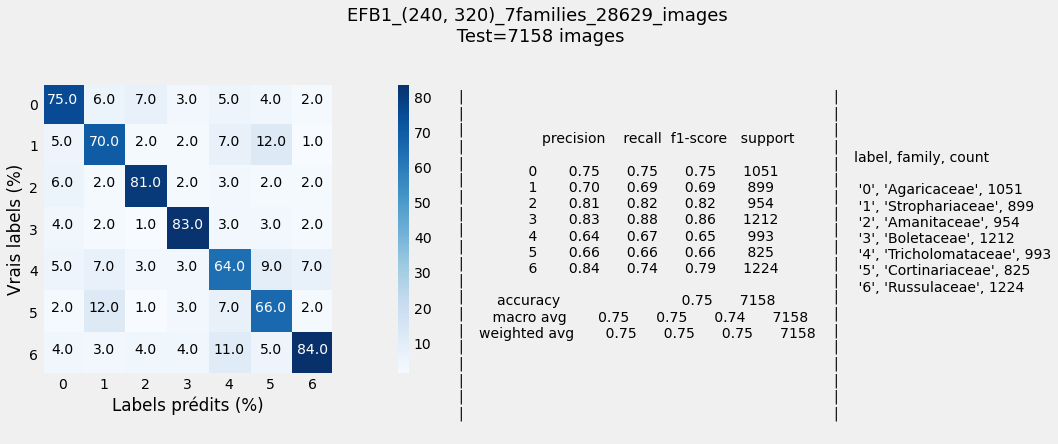

time: 1.1 s (started: 2022-02-21 13:39:19 +00:00)


In [ ]:
# true label
y_test_class= df_test['label'].values.astype(int)
print("*"*50 + 'TEST set classification report' + '*'*50)
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + '_classification report.csv'
report.to_csv(report_path)
# conf matrix 
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')

# SVC classifier

In [ ]:
from sklearn.svm import SVC

time: 732 µs (started: 2022-02-21 13:39:20 +00:00)


In [ ]:
layer_number  = 3 
print('DL model layer output = {}'.format(model.layers[layer_number].name))
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_number].output)

DL model layer output = dropout
time: 9.21 ms (started: 2022-02-21 13:39:20 +00:00)


In [ ]:
# predict features with neural net on WHOLE TRAIN and test
train_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_train, #/!\ vs df_train_
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match label order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
X_train_features = intermediate_layer_model.predict(train_generator)
#test 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match label order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
X_test_features = intermediate_layer_model.predict(test_generator)

Found 28629 validated image filenames belonging to 7 classes.
Found 7158 validated image filenames belonging to 7 classes.
time: 2min 47s (started: 2022-02-21 13:39:20 +00:00)


In [ ]:
# define target on WHOLE TRAIN and test
y_train ,  y_test = df_train['label'] , df_test['label']

time: 1.38 ms (started: 2022-02-21 13:42:08 +00:00)


In [ ]:
# define SVC
best_mod = SVC(C=1)

time: 658 µs (started: 2022-02-21 13:42:08 +00:00)


In [ ]:
# fit 
best_mod.fit(X_train_features, y_train)

SVC(C=1)

time: 3min 26s (started: 2022-02-21 13:42:08 +00:00)


In [ ]:
# predict label
test_pred_class = best_mod.predict(X_test_features).astype(int)

time: 1min 42s (started: 2022-02-21 13:45:34 +00:00)


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1051
           1       0.70      0.73      0.71       899
           2       0.82      0.84      0.83       954
           3       0.87      0.87      0.87      1212
           4       0.66      0.66      0.66       993
           5       0.69      0.66      0.68       825
           6       0.80      0.79      0.80      1224

    accuracy                           0.76      7158
   macro avg       0.76      0.76      0.76      7158
weighted avg       0.76      0.76      0.76      7158



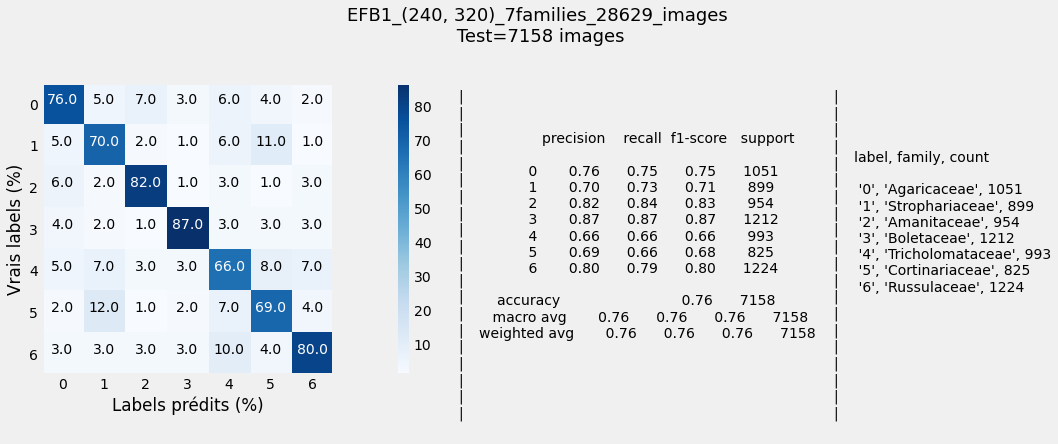

time: 1.07 s (started: 2022-02-21 13:47:16 +00:00)


In [ ]:
# true label
y_test_class= df_test['label'].values.astype(int)
print("*"*50 + 'TEST set classification report' + '*'*50)
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + '_classification report.csv'
report.to_csv(report_path)
# conf matrix 
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir +  'Hybrid_model_conf_matrix.jpeg' ,bbox_inches = 'tight')